In [1]:
import cellbox
import os
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import shutil
import argparse
import json
import glob
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

tf.disable_v2_behavior()

2023-07-29 22:27:45.589087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 22:27:45.758252: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-29 22:27:45.762755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/lsf10/10.1/linux3.10-glibc2.17-x86_64/lib:/data/weirauchlab/opt/lib

Instructions for updating:
non-resource variables are not supported in the long term
   _____     _ _ ____              
  / ____|   | | |  _ \             
 | |     ___| | | |_) | _____  __  
 | |    / _ \ | |  _ < / _ \ \/ /  
 | |___|  __/ | | |_) | (_) >  <   
  \_____\___|_|_|____/ \___/_/\_\  
Running CellBox scripts developed in Sander lab
Maintained by Bo Yuan, Judy Shen, and Augustin Luna; contributions by Daniel Ritter

        version 0.3.2
        -- Feb 10, 2023 --
        * Modify CellBox to support TF2     
        
Tutorials and documentations are available at https://github.com/sanderlab/CellBox
If you want to discuss the usage or to report a bug, please use the 'Issues' function at GitHub.
If you find CellBox useful for your research, please consider citing the corresponding publication.
For more information, please email us at boyuan@g.harvard.edu and c_shen@g.harvard.edu, augustin_luna@hms.harvard.edu
 ----------------------------------------------------------------

In [2]:
# Manually determine the params and all other necessary params
class KernelConfig(object):
    def __init__(self):
        
        self.n_x = 99
        self.envelope_form = "clip linear" # options: tanh, polynormial, hill, linear, clip linear
        self.envelope_fn = None
        self.polynomial_k = 2 # larger than 1
        self.ode_degree = 1
        self.envelope = 0
        self.ode_solver = "euler" # options: euler, heun, rk4, midpoint
        self.dT = 0.1
        self.ode_last_steps = 2
        self.n_T = 100
        self.gradient_zero_from = None

args = KernelConfig()
dT = 0.1
n_T = 100
gradient_zero_from = None

#if self.args.envelope == 2:
#    psi = tf.Variable(np.ones((n_x, 1)), name="psi", dtype=tf.float32)
#    self.params['psi'] = tf.nn.softplus(psi)

pert_data = pd.read_csv("/users/ngun7t/Documents/cellbox-jun-6/data/pert.csv", header=None)
print(pert_data.shape)

(89, 99)


In [3]:
W = np.random.normal(loc=0.01, size=(args.n_x, args.n_x))
eps = np.ones((args.n_x, 1), dtype=np.float32)
alpha = np.ones((args.n_x, 1), dtype=np.float32)
y0_np = np.zeros((args.n_x, 4))
#mu_t_np = pert_data[:4].T
mu_t_np = np.random.normal(loc=0.01, size=(4, args.n_x)).T
ytrue_np = np.random.normal(size=(args.n_x, 4)).T

### Tensorflow code

In [5]:
# import the relevant objects
def tensorflow_results():
    from cellbox.kernel import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    params["alpha"] = tf.convert_to_tensor(np.log(np.exp(alpha) + 1), dtype=tf.float32)
    params["eps"] = tf.convert_to_tensor(np.log(np.exp(eps) + 1), dtype=tf.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = tf.convert_to_tensor(y0_np, dtype=tf.float32)
    mu_t = tf.convert_to_tensor(mu_t_copy, dtype=tf.float32)
    ys = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)
    return ys.eval(session=tf.compat.v1.Session())

In [6]:
ys_tf = tensorflow_results()

2023-07-27 12:04:52.939418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/lsf10/10.1/linux3.10-glibc2.17-x86_64/lib:/data/weirauchlab/opt/lib:/data/weirauchlab/opt/lib64:/data/weirauchlab/local/lib:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/
2023-07-27 12:04:52.939490: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-27 12:04:52.939554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bmiclusterp2.chmcres.cchmc.org): /proc/driver/nvidia/version does not exist
2023-07-27 12:04:52.940097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorF

### Check Pytorch code

In [24]:
# import the relevant objects
def pytorch_results():
    from cellbox.kernel_torch import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    params["alpha"] = torch.tensor(np.log(np.exp(alpha) + 1), dtype=torch.float32)
    params["eps"] = torch.tensor(np.log(np.exp(eps) + 1), dtype=torch.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = torch.tensor(y0_np, dtype=torch.float32)
    mu_t = torch.tensor(mu_t_copy, dtype=torch.float32)
    ys_torch = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)

    return ys_torch.numpy()

In [25]:
ys_torch = pytorch_results()

### Analyse results

The plot that shows the maximum and average difference between two functions

In [26]:
#n_T_list = list(range(5, 405, 5))
#diff_max_list = []
#diff_mean_list = []
#for n_T in n_T_list:
#    args.n_T = n_T
#    print(f"Working on time step: {n_T}")
#    tf_out = tensorflow_results()
#    torch_out = pytorch_results()
#    diff_max_list.append(np.amax(np.abs(tf_out - torch_out)))
#    diff_mean_list.append(np.mean(np.abs(tf_out - torch_out)))

assert ys_tf.shape == ys_torch.shape, "The shape of two tensors is not equal"
diff_max_list = []
diff_mean_list = []
for t in range(ys_torch.shape[0]):
    tf_slice = ys_tf[t, ...]
    torch_slice = ys_torch[t, ...]
    diff_max_list.append(np.amax(np.abs(torch_slice - tf_slice)))
    diff_mean_list.append(np.mean(np.abs(torch_slice - tf_slice)))

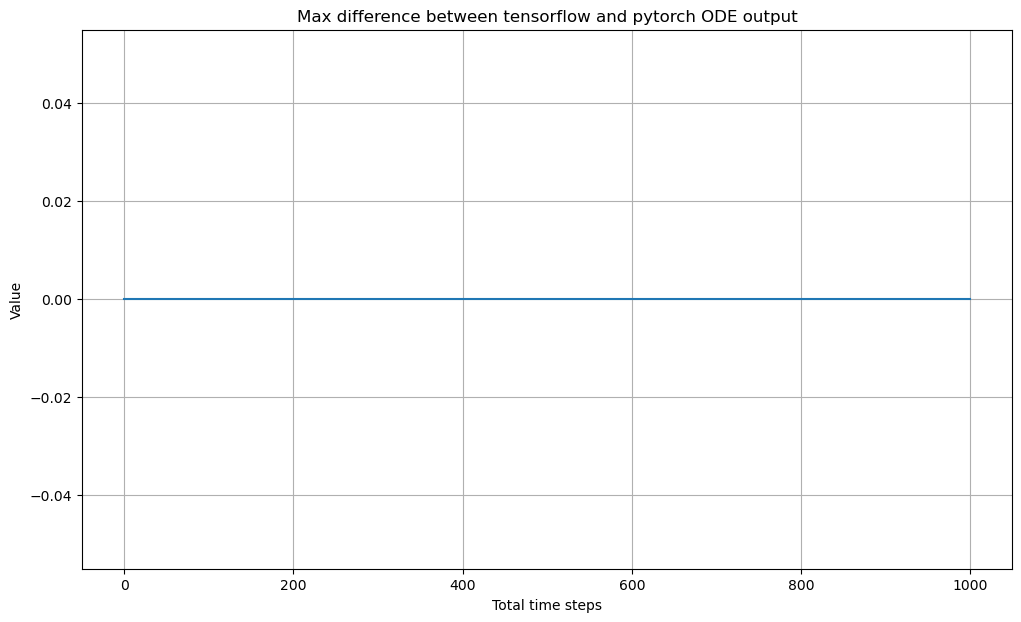

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(diff_max_list)
#plt.xticks(np.arange(len(n_T_list)), n_T_list, rotation=90)
plt.title("Max difference between tensorflow and pytorch ODE output")
plt.xlabel("Total time steps")
plt.ylabel("Value")
plt.grid()
plt.show()

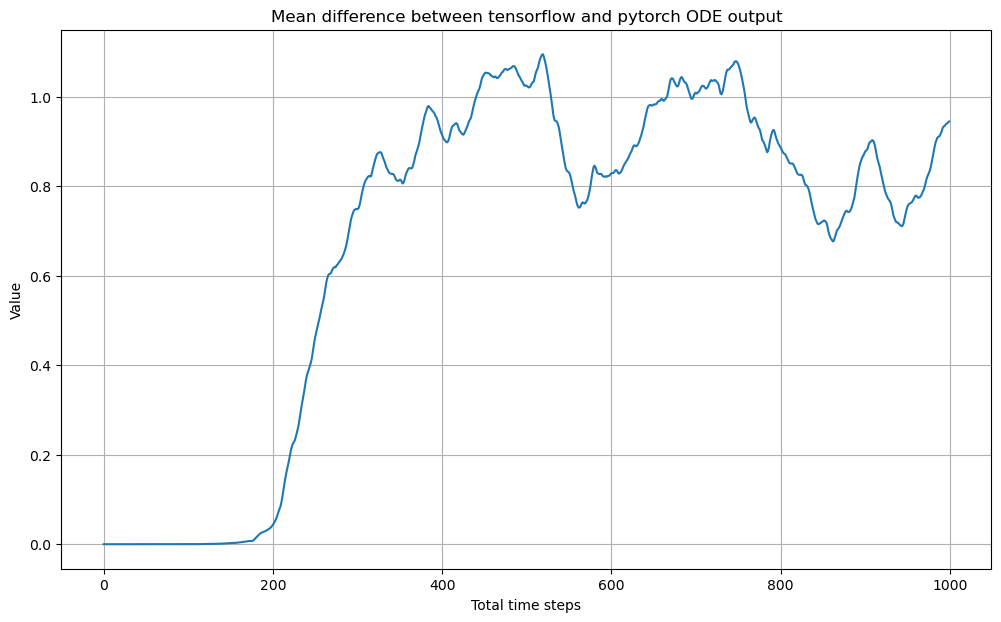

In [10]:
plt.figure(figsize=(12, 7))
plt.plot(diff_mean_list)
#plt.xticks(np.arange(len(n_T_list)), n_T_list, rotation=90)
plt.title("Mean difference between tensorflow and pytorch ODE output")
plt.xlabel("Total time steps")
plt.ylabel("Value")
plt.grid()
plt.show()

Show the actual output of two functions

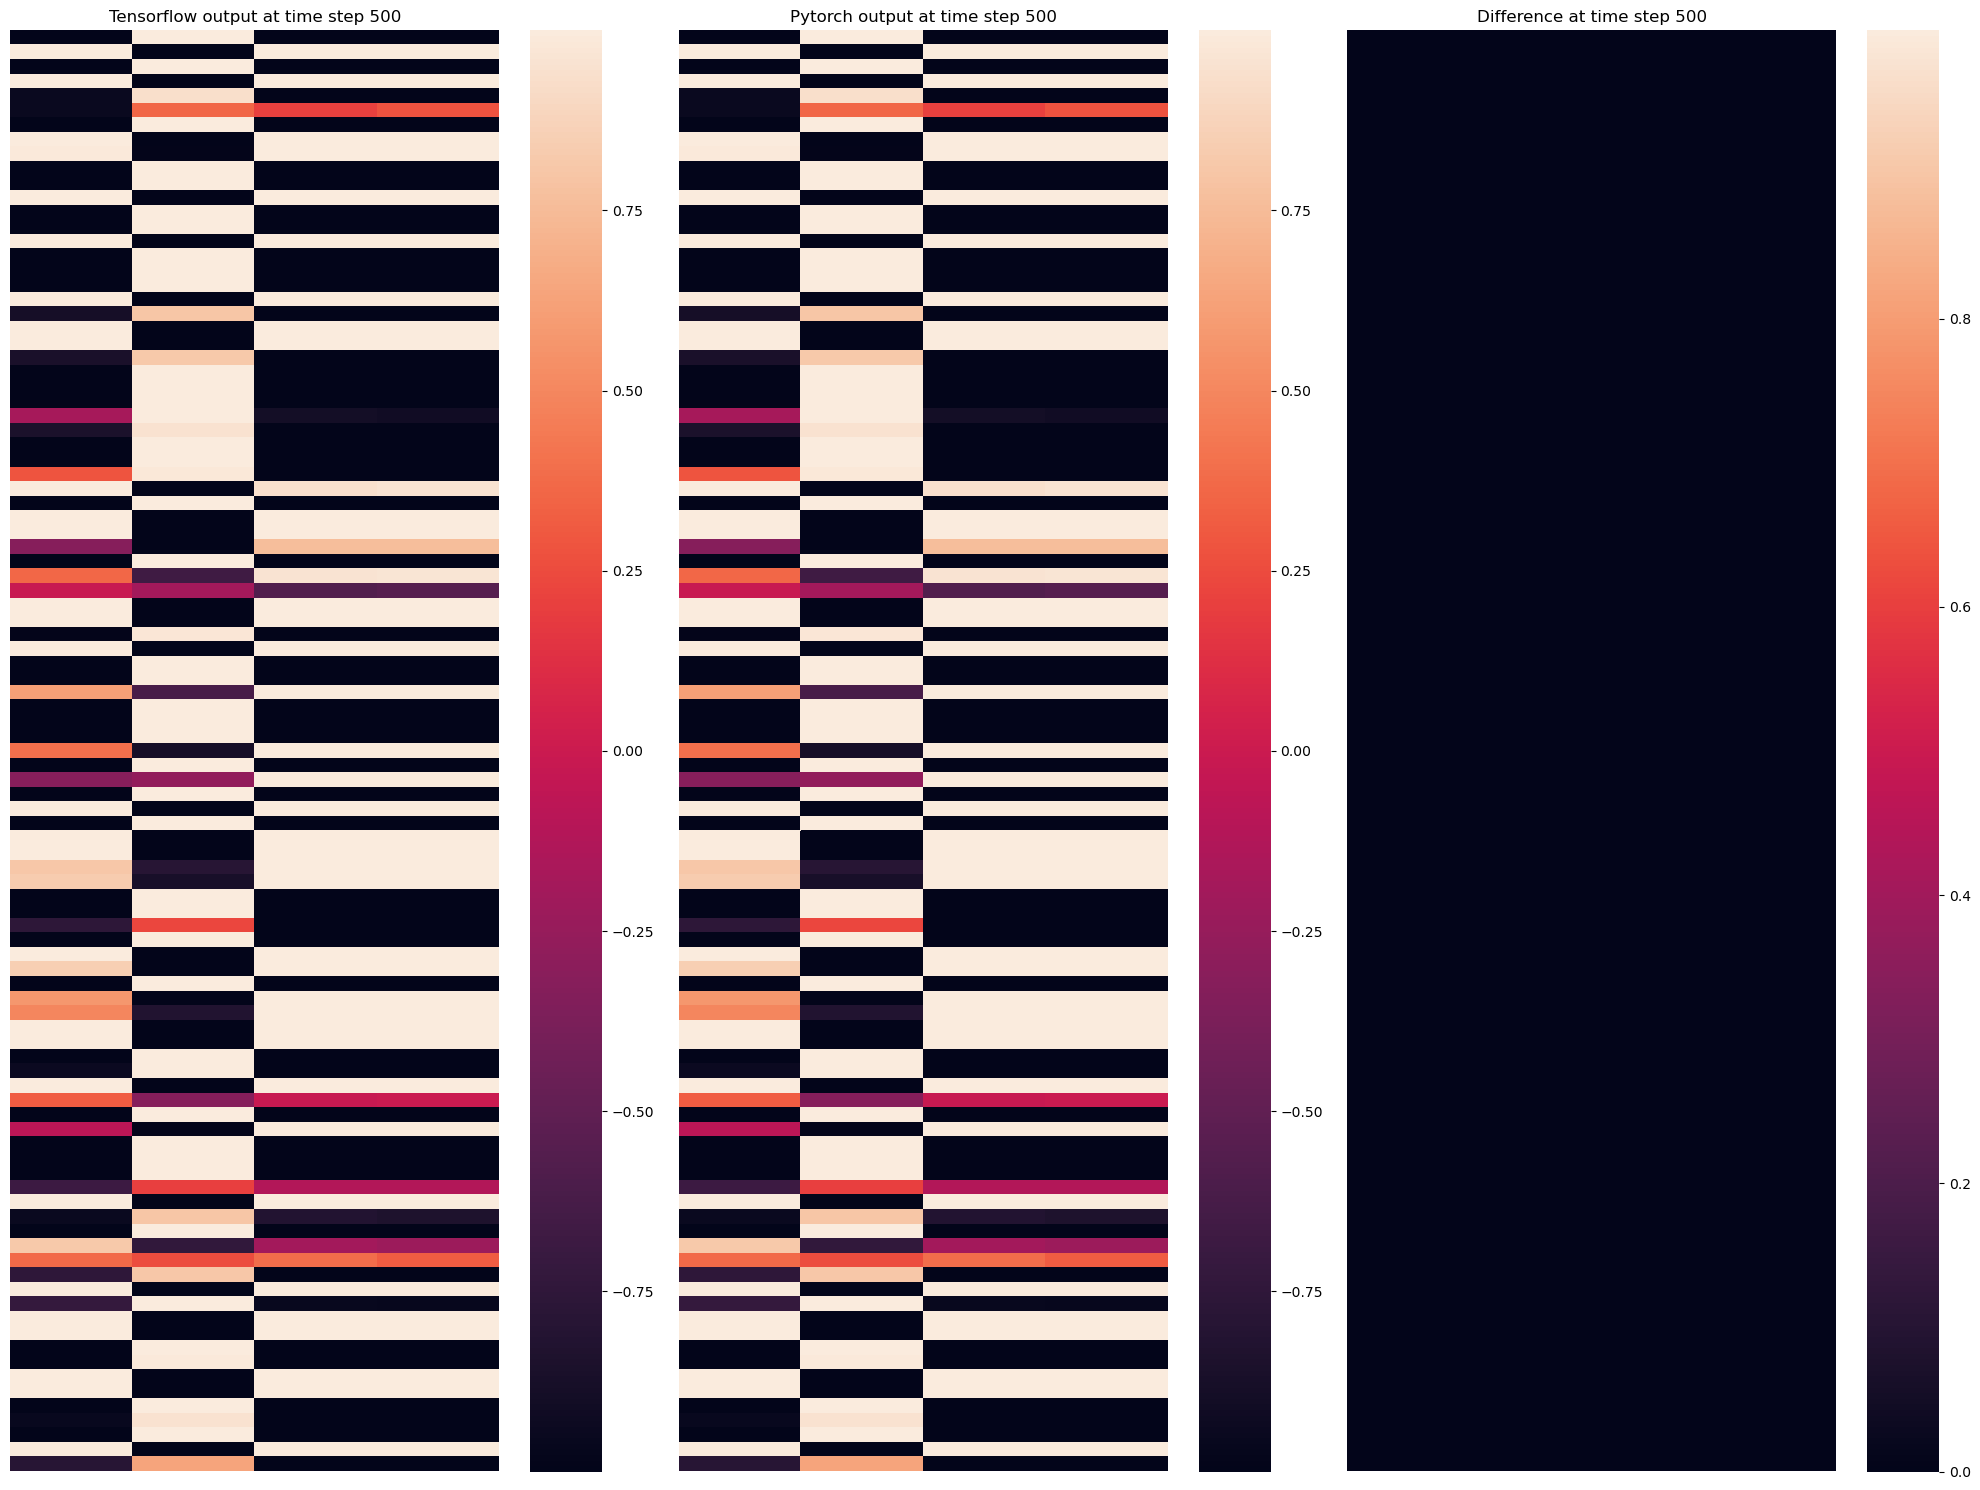

In [22]:
time_step = 500
tf_slice = ys_tf[time_step, ...]
torch_slice = ys_torch[time_step, ...]
diff_slice = np.abs(tf_slice - torch_slice)
max_val = np.amax(np.concatenate([tf_slice, torch_slice, diff_slice]))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 15), sharey=True)
sns.heatmap(tf_slice, ax=axes[0], vmax=max_val)
axes[0].set_title(f"Tensorflow output at time step {time_step}")
axes[0].set_axis_off()
sns.heatmap(torch_slice, ax=axes[1], vmax=max_val)
axes[1].set_title(f"Pytorch output at time step {time_step}")
axes[1].set_axis_off()
sns.heatmap(diff_slice, ax=axes[2], vmax=max_val)
axes[2].set_title(f"Difference at time step {time_step}")
axes[2].set_axis_off()
plt.tight_layout()
plt.show()

### Test envelope function of the code

In [31]:
W_like = np.random.randn(99, 99)

In [8]:
# Test the envelope
def tensorflow_envelope():
    from cellbox.kernel import get_envelope
    envelope_fn = get_envelope(args)

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    if args.ode_degree == 1:
        def weighted_sum(x):
            return tf.matmul(params['W'], x)
    
    return envelope_fn(weighted_sum(tf.convert_to_tensor(params["W"], dtype=tf.float32))).eval(session=tf.compat.v1.Session())
    
def pytorch_envelope():
    from cellbox.kernel_torch import get_envelope
    envelope_fn = get_envelope(args)
    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    if args.ode_degree == 1:
        def weighted_sum(x):
            return torch.matmul(params['W'], x)

    return envelope_fn(weighted_sum(torch.tensor(params["W"], dtype=torch.float32))).numpy()


In [9]:
tf_out = tensorflow_envelope()
torch_out = pytorch_envelope()

2023-07-22 13:22:48.894174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/lsf10/10.1/linux3.10-glibc2.17-x86_64/lib:/data/weirauchlab/opt/lib:/data/weirauchlab/opt/lib64:/data/weirauchlab/local/lib:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/
2023-07-22 13:22:48.894248: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-22 13:22:48.894309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bmiclusterp2.chmcres.cchmc.org): /proc/driver/nvidia/version does not exist
2023-07-22 13:22:48.895432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorF

A small difference indicates that the envelope function produces similar results

In [11]:
print(np.abs(tf_out - torch_out))

[[0.0000000e+00 1.4901161e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [5.9604645e-08 0.0000000e+00 5.9604645e-08 2.9802322e-08 5.9604645e-08]
 [1.1920929e-07 0.0000000e+00 9.3132257e-10 0.0000000e+00 2.9802322e-08]
 [2.9802322e-08 1.4901161e-08 5.9604645e-08 1.8626451e-09 5.9604645e-08]
 [5.9604645e-08 5.9604645e-08 5.9604645e-08 0.0000000e+00 0.0000000e+00]]


Using clip linear

In [12]:
args.envelope_form = "clip linear"
tf_out = tensorflow_envelope()
torch_out = pytorch_envelope()
print(np.abs(tf_out - torch_out))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


/tmp/ipykernel_12863/4065529084.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return envelope_fn(weighted_sum(torch.tensor(params["W"], dtype=torch.float32))).numpy()


Using polynomial

In [14]:
args.envelope_form = "polynomial"
args.polynomial_k = 2
tf_out = tensorflow_envelope()
torch_out = pytorch_envelope()
print(np.abs(tf_out - torch_out))

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 5.9604645e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.4551915e-11 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


/tmp/ipykernel_12863/4065529084.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return envelope_fn(weighted_sum(torch.tensor(params["W"], dtype=torch.float32))).numpy()


### Test dXdT of the code

In [41]:
def tensorflow_dxdt():
    from cellbox.kernel import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = tf.convert_to_tensor(W_copy, dtype=tf.float32)
    params["alpha"] = tf.convert_to_tensor(np.log(np.exp(alpha) + 1), dtype=tf.float32)
    params["eps"] = tf.convert_to_tensor(np.log(np.exp(eps) + 1), dtype=tf.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = tf.convert_to_tensor(y0_np, dtype=tf.float32)
    mu_t = tf.convert_to_tensor(mu_t_copy, dtype=tf.float32)
    return _dxdt(y0, mu_t).eval(session=tf.compat.v1.Session())

def pytorch_dxdt():
    from cellbox.kernel_torch import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = torch.tensor(W_copy, dtype=torch.float32)
    params["alpha"] = torch.tensor(np.log(np.exp(alpha) + 1), dtype=torch.float32)
    params["eps"] = torch.tensor(np.log(np.exp(eps) + 1), dtype=torch.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = torch.tensor(y0_np, dtype=torch.float32)
    mu_t = torch.tensor(mu_t_copy, dtype=torch.float32)
    return _dxdt(y0, mu_t).numpy()

In [42]:
tf_out = tensorflow_dxdt()
torch_out = pytorch_dxdt()

In [43]:
np.amax(np.abs(tf_out - torch_out))

2.3841858e-07

### Test numerical discrepancy between Tensorflow and Pytorch

Tanh function

In [27]:
a = np.linspace(-2, 2, 25)
tf_out = tf.tanh(tf.convert_to_tensor(a, dtype=tf.float32)).eval(session=tf.compat.v1.Session())
torch_out = torch.tanh(torch.tensor(a, dtype=torch.float32)).numpy()

print(np.abs(tf_out - torch_out))

[0.0000000e+00 5.9604645e-08 5.9604645e-08 5.9604645e-08 5.9604645e-08
 5.9604645e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.9802322e-08 1.4901161e-08 0.0000000e+00 1.4901161e-08 2.9802322e-08
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.9604645e-08
 5.9604645e-08 5.9604645e-08 5.9604645e-08 5.9604645e-08 0.0000000e+00]


### Test gradient flow through ODE solver for tensorflow

In [4]:
# import the relevant objects
def tensorflow_results_last_steps():
    from cellbox.kernel import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    with tf.compat.v1.variable_scope("initialization", reuse=True):
        params["W"] = tf.Variable(W_copy, name="W", dtype=tf.float32)
        params["alpha"] = tf.Variable(np.log(np.exp(alpha) + 1), name="alpha", dtype=tf.float32)
        params["eps"] = tf.Variable(np.log(np.exp(eps) + 1), name="eps", dtype=tf.float32)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = tf.convert_to_tensor(y0_np, dtype=tf.float32)
    mu_t = tf.convert_to_tensor(mu_t_copy, dtype=tf.float32)
    ys = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)
    ys = ys[-args.ode_last_steps:]
    yhat = tf.transpose(ys[-1])

    return yhat, params

In [5]:
from cellbox.utils import loss

ys_tf_last_step, params_tf = tensorflow_results_last_steps()
loss_total, loss_mse = loss(tf.convert_to_tensor(ytrue_np, dtype=tf.float32), ys_tf_last_step, W=params_tf["W"], l1=tf.convert_to_tensor(0.1, dtype=tf.float32), l2=tf.convert_to_tensor(0.01, dtype=tf.float32))

all_global_variables = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES)
gradients = tf.gradients(loss_total, all_global_variables)[-3:]

# Start a TensorFlow session
with tf.compat.v1.Session() as sess:
    # Initialize all global variables in the graph
    sess.run(tf.compat.v1.global_variables_initializer())

    # Get the values of the gradients
    gradients_values = sess.run(gradients)

    # Print the gradients and their corresponding variable names
    for var, grad_value in zip(all_global_variables, gradients_values):
        print(f"Variable: {var.name}, Gradient: {grad_value}")

2023-07-29 22:28:54.969014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/lsf10/10.1/linux3.10-glibc2.17-x86_64/lib:/data/weirauchlab/opt/lib:/data/weirauchlab/opt/lib64:/data/weirauchlab/local/lib:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/:/users/ngun7t/anaconda3/envs/cellbox-3.6-2/lib/
2023-07-29 22:28:54.969105: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-29 22:28:54.969170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bmiclusterp2.chmcres.cchmc.org): /proc/driver/nvidia/version does not exist
2023-07-29 22:28:54.970447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorF

Variable: initialization/W:0, Gradient: [[  0.69046104   0.31123114  -0.7850424  ...   0.19063      0.24119295
    0.19511142]
 [  0.90136296   3.554258    -2.8723724  ...   2.7796693   -3.0637
   -0.4621172 ]
 [  0.59431875  -2.8392217    0.11265766 ...  -1.9162074    0.21832827
    2.2832265 ]
 ...
 [ -2.4562578   -0.4884661   -3.0537615  ...   1.9585688   -1.2582976
   -1.1611881 ]
 [  1.6098921   -0.21719028   1.2967887  ...  -2.1975315    1.0968386
    2.0762997 ]
 [-10.598585     2.5337548   -4.4799414  ...   7.062887    -4.01558
   -7.3086348 ]]
Variable: initialization/alpha:0, Gradient: [[-2.0036108e+01]
 [ 8.4304628e+00]
 [ 4.3131747e+00]
 [ 4.1822430e+01]
 [ 3.0720057e+01]
 [ 9.9886761e+00]
 [-4.7925096e+00]
 [ 1.1153275e+01]
 [-1.7794771e+01]
 [ 9.5031309e+00]
 [ 1.8042181e+01]
 [-4.5810402e+01]
 [-5.4681501e+00]
 [ 4.9538124e+01]
 [-4.0876279e+00]
 [ 2.6752725e+00]
 [ 2.3386414e+01]
 [ 3.5430417e+00]
 [ 1.9863934e+01]
 [ 1.4180571e+01]
 [ 2.1204237e+01]
 [-1.4273623e+00]
 

In [7]:
gradients_values[0][0, :50]

array([ 0.69046104,  0.31123114, -0.7850424 ,  0.46294522,  0.4425201 ,
       -0.17243925,  0.34404165,  0.08361699, -0.5427679 , -0.11015718,
        0.03010625, -0.37424648, -0.56145036, -0.42048973,  0.48005337,
       -0.02569393, -0.3123778 , -0.09902008,  0.61767304,  0.00238466,
        0.06244864, -0.3778721 , -0.5482499 ,  0.3120805 ,  0.2579922 ,
       -0.5806424 ,  0.12324258,  0.1298736 ,  0.19978786,  0.568104  ,
        0.08225629, -0.3661679 , -0.32986036, -0.05421277, -0.24041432,
       -0.5577585 ,  0.4246444 , -0.875781  , -0.14590715,  0.31604806,
       -0.25848472, -0.24543023,  0.82239693, -0.26378253,  0.01115453,
        0.06397022, -0.14723325, -0.07654066,  0.47561085, -0.57069266],
      dtype=float32)

tensor([ 0.6920,  0.3076, -0.7879,  0.4600,  0.4459, -0.1765,  0.3411,  0.0888,
        -0.5380, -0.1136,  0.0344, -0.3713, -0.5647, -0.4160,  0.4748, -0.0288,
        -0.3091, -0.0975,  0.6124,  0.0067,  0.0576, -0.3814, -0.5438,  0.3148,
         0.2547, -0.5764,  0.1251,  0.1282,  0.2024,  0.5642,  0.0872, -0.3702,
        -0.3329, -0.0548, -0.2371, -0.5608,  0.4198, -0.8708, -0.1430,  0.3199,
        -0.2626, -0.2490,  0.8195, -0.2636,  0.0140,  0.0593, -0.1501, -0.0734,
         0.4719, -0.5692])

### Test gradient flow through ODE solver for pytorch

In [8]:
# import the relevant objects
def pytorch_results_last_steps():
    from cellbox.kernel_torch import get_ode_solver, get_envelope, get_dxdt

    params = {}
    W_copy = np.copy(W)
    params["W"] = nn.Parameter(torch.tensor(W_copy, dtype=torch.float32), requires_grad=True)
    params["alpha"] = nn.Parameter(torch.tensor(np.log(np.exp(alpha) + 1), dtype=torch.float32), requires_grad=True)
    params["eps"] = nn.Parameter(torch.tensor(np.log(np.exp(eps) + 1), dtype=torch.float32), requires_grad=True)
    envelope_fn = get_envelope(args)
    ode_solver = get_ode_solver(args)
    _dxdt = get_dxdt(args, params)

    # Determine the input and output shape of the ODE
    mu_t_copy = np.copy(mu_t_np)
    y0 = torch.tensor(y0_np, dtype=torch.float32)
    mu_t = torch.tensor(mu_t_copy, dtype=torch.float32)
    ys_torch = ode_solver(y0, mu_t, args.dT, args.n_T, _dxdt, gradient_zero_from)
    ys_torch = ys_torch[-args.ode_last_steps:]
    yhat = torch.transpose(ys_torch[-1], 0, 1)

    return yhat, params

In [9]:
ys_torch_last_step, params = pytorch_results_last_steps()

In [10]:
from cellbox.utils_torch import loss

loss_val, _ = loss(torch.tensor(ytrue_np, dtype=torch.float32), ys_torch_last_step, W=params["W"], l1=0.1, l2=0.01)
gradient = torch.autograd.grad(loss_val, params["W"])

In [54]:
gradient[0]

tensor([[-0.1420, -0.0137, -0.0020,  ...,  0.0839,  0.1973, -0.1159],
        [ 0.0522, -0.1596, -0.2373,  ...,  0.1347,  0.1080,  0.3734],
        [-0.5585, -0.0289,  0.9152,  ..., -0.3465,  0.1889, -1.1914],
        ...,
        [-0.2433,  0.2777, -0.3912,  ...,  0.2999, -0.9269,  0.1279],
        [ 0.2351, -0.5944,  0.3630,  ..., -0.2594,  0.1063,  0.1603],
        [ 0.9058, -0.9875,  0.3528,  ..., -0.5885,  0.2372, -0.1451]])

In [71]:
ys_torch_last_step_detached = ys_torch_last_step.detach()
loss_val, _ = loss(torch.tensor(ytrue_np, dtype=torch.float32), ys_torch_last_step_detached, W=params["W"], l1=0.1, l2=0.01)
gradient = torch.autograd.grad(loss_val, params["W"])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [11]:
gradient[0][0, :50]

tensor([ 0.6920,  0.3076, -0.7879,  0.4600,  0.4459, -0.1765,  0.3411,  0.0888,
        -0.5380, -0.1136,  0.0344, -0.3713, -0.5647, -0.4160,  0.4748, -0.0288,
        -0.3091, -0.0975,  0.6124,  0.0067,  0.0576, -0.3814, -0.5438,  0.3148,
         0.2547, -0.5764,  0.1251,  0.1282,  0.2024,  0.5642,  0.0872, -0.3702,
        -0.3329, -0.0548, -0.2371, -0.5608,  0.4198, -0.8708, -0.1430,  0.3199,
        -0.2626, -0.2490,  0.8195, -0.2636,  0.0140,  0.0593, -0.1501, -0.0734,
         0.4719, -0.5692])